## MTH9878 Interest Rate Models HW1
* Group X
* Author: Pan, Hongchao & Zhang, Chendi
* Kernel version: Python 2.7
* Packages: 
* Data: 
* Notes:

In [196]:
# load packages and features from version 3.x
from __future__ import absolute_import, print_function, division
import pandas as pd
import numpy as np
import math
import datetime   # create datetime object
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, splrep,splev

### Answer of Q1

In [48]:
# Define a function to calculate the faction of the date differnence
def date_fraction(t1,t2):
    # Assume input t1 and t2 are calendar dates with datetime objects
    # Use the date convention: actual days/360
    return ((t2-t1).days)/360   

In [3]:
# Define a funtion to compute the integration by using simpson's rule
# a: left endpoint; b: right endpoint; n: number of partition intervals
# f: instantaneous rate function, f(s)
def simpson_rule(a,b,f,n):
    h= (b-a)/n
    result=(f(a) + f(b))/6

    for i in range(1, n):
        result += f(a + i*h)/3
    for i in range(1, n+1):
        result += 2*f(a + (i-0.5)*h)/3

    return result*h

In [4]:
def approx_val_tol(f_method,a,b,f,n,tol):
    """
    # f_method: integration method: mid_point/trape/simpson method; simpson's rule here
    # tol=5e-7
    # n: number of partition intervals
    # f: instantaneous rate function, f(s)
    # a: left endpoint, t here; b: right endpoint, T here;
    """
    # By using double strategy to converge
    result_old=f_method(a,b,f,n)
    n=2*n
    result_new=f_method(a,b,f,n)

    while(abs(result_old-result_new)>tol):
        result_old=result_new
        n=2*n
        result_new=f_method(a,b,f,n)

    return result_new


In [5]:
# Define the interest rate function
# the constant interest rate
def f_const(x):
    # example from given spreedsheet
    return 0.55/100   

# instantaneous rate, not the case in this homework
def f_instant(x):
    # Arbitrary example
    return math.exp(-x^2)

In [6]:
# Define a function to compute the discount factor
def dist(t,T,f,flag):
    """
    # t: starting date
    # T: maturity
    # f: interest rate
    # flag: indicator of f is constant rate or instantaneous rate
    """
    # Assume input t and T are calendar dates with month notation
    
    # Get the day fraction
    day_frac=date_fraction(t,T)
    if(flag=='c'):
        # constant interest rate
        return math.exp(-f*day_frac)
    if(flag=='i'):
        # instantaneous rate
        # starting intervals: 4
        # tolerance: 5e-7
        # Since t and T are calendar date, convert them to get day fraction period,
        # which is equivalent to 0 to day_frac
        return math.exp(-approx_val_tol(simpson_rule,0,day_frac,f,4,5e-7))
    else:
        print("The inputs of are not well defined.")
        return -2

### Answer of Q2

In [249]:
# define a function to calculate the LIBOR forward rate
# reference formula: equation (12) in lecture 1
def LFR(t,S,T,I,flag):
    """
    # t: spot/observation date
    # S: settlement date
    # T: maturity
    # I: instantaneous forward rate
    # T-S: underlying tenor
    # flag: indicator of I is constant or function
    # Assume input t and T are calendar dates with month notation
    """
    
    # get the day fraction
    day_frac=date_fraction(S,T)
   
    if(flag=='c'):
        # constant interest rate
        return (math.exp(I*day_frac)-1)/day_frac  # equation (12) in lecture 1
    if(flag=='i'):
        # instantaneous rate
        # starting intervals: 4
        # tolerance: 5e-7
        # Since t and T are calendar date, convert them to get day fraction period,
        # which is equivalent to 0 to day_frac
        return (math.exp(approx_val_tol(simpson_rule,0,day_frac,I,4,5e-7))-1)/day_frac
    else:
        print("The inputs are not well defined.")
        return -2
    

### Answer of Q3

In [8]:
# define a function to compute the cash flow date and value
def calculate_flow(coupon, frequency, T0,maturity):
    """
    :param coupon: in dollars
    :param frequency: is an int
    :param T0: obeservation date, in datetime object
    :param maturity: in datetime object
    :return: intervals scaled by years
    "This functon calculates cash flow dates and values."
    """
    
    flow_date=range(maturity,T0,int(-12/frequency))
    flow_date.reverse()
    flow_date=[t/12 for t in flow_date]   # Convert the date

    flow_value=[coupon/frequency for i in flow_date[:-1]]+[coupon/frequency]
    # flow_date[:-1] remove the last elements in the list
    return flow_date, flow_value


In [9]:
# Define a funtion to compute the spot/forward swap rate
# Reference: break-even swap rate, equation (19) in lecture note 1
def BE_swap_rate(coupon_f,frequency_f,f_f,flag_f,
                 coupon_L,frequency_L,f_L,flag_L,
                 t,T0,maturity):
    """
    _f: parameters in fix leg
    _L: parameters in LIBOR
    :param coupon: in dollars
    :param frequency: is an int
    :param t: spot date, usually 0
    :param T0: obeservation date, in datetime object
    :param maturity: in datetime object
    :param f: interest rate
    :param flag: indicator of interest rate is constant or function
    """
    
    # Compute the annuity
    flow_date_fix,flow_value_fix=calculate_flow(coupon_f,frequency_f,T0,maturity)
    # flow_date is alpha_j in the equation (16)
    # flow_value is future cash flows
    # compute the discount factors
    df=[]
    df_append=df.append  # avoid .operation to speed up the computation
    
    for i in range(len(flow_date_fix)):
        df_append(dist(t,flow_date_fix[i],f_f,flag_f))
    
    annuity_t=sum(a*b for a,b in zip(flow_date,df))
    
    # Compute the payment of floating leg
    # Compute the flow date
    flow_date_L, flow_cash_L=calculate_flow(coupon_L,frequency_L,T0,maturity)
    # flow_date is delta_j in the equation (17)
    # flow_value is future cash flows
    # compute the discount factors
    df_L=[]
    df_L_append=df_L.append  # avoid .operation to speed up the computation
    
    for i in range(len(flow_date_L)):
        df_L_append(dist(t,flow_date_L[i],f_L,flag_L))
    
    # compute the Lj in equation (17)
    Lj=[]
    Lj_append=Lj.append
    
    for i in range(len(flow_date_L)-1):
        LJ_append(LFR(0,flow_date_L[i],flow_date_L[i+1],f_L,flag_L))
    
    P_float=sum([x*y*z for x,y,z in zip(flow_date_L,Lj,df_L)])

    return P_float/annuity_t   # break-even swap rate
    
    

### Answer of Q4

In [239]:
# Define a function to read the data from given excel file
def get_data():
    file_name='DataSheetCurve.xls'
    # activate sheet: 2nd sheet
    
    # LIBOR
    df_LIB=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:E",skiprows=1)[:2]
    
    # ED Futures
    df_EDF=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:F",skiprows=5)[:8]
    
    # Swap Rates
    df_Swap=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:E",skiprows=15)[:11]
    
    # Fed Funds
    df_Fed=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:E",skiprows=28)[:1]
    
    # Basis Swap Rates
    df_BSwap=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:E",skiprows=32)[:16]
    
    # Rename the 1st column name
    df_LIB.rename(columns={df_LIB.columns[0]:'Instruments'},inplace=True)
    df_EDF.rename(columns={df_EDF.columns[0]:'Instruments'},inplace=True)
    df_Swap.rename(columns={df_Swap.columns[0]:'Instruments'},inplace=True)
    df_Fed.rename(columns={df_Fed.columns[0]:'Instruments'},inplace=True)
    df_BSwap.rename(columns={df_BSwap.columns[0]:'Instruments'},inplace=True)
    
    # Compute the year fraction of duration (end date- start date)
    df_LIB['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_LIB['Start Date'],df_LIB['End Date'])]
    df_Swap['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_Swap['Start Date'],df_Swap['End Date'])]
    df_Fed['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_Fed['Start Date'],df_Fed['End Date'])]
    df_BSwap['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_BSwap['Start Date'],df_BSwap['End Date'])]
    # For Eurodollar futures: start date: 12/15/2011, end date: IMM date
    # Same as 3M LIBOR start date
    df_EDF['Start Date']=datetime.datetime(2011,12,15,0,0,0,0)
    df_EDF['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_EDF['Start Date'],df_EDF['IMM date'])]
    
    df_BSwap['Basis (bp)'] = df_BSwap['Basis (bp)']*1e-4  # basis point
    
    return df_LIB, df_EDF, df_Swap, df_Fed, df_BSwap

In [240]:
df_LIB, df_EDF, df_Swap, df_Fed, df_BSwap=get_data()

In [212]:
df_LIB

,Instruments,Start Date,End Date,Rate,Year Fraction of Duration
0,USD O/N,2011-12-13 00:00:00,2011-12-14 00:00:00,0.0054588,0.002778
1,USD 3M,2011-12-15 00:00:00,2012-03-15 00:00:00,0.0054625,0.252778


In [213]:
df_EDF

,Instruments,IMM date,Price,Conv. Adj. (bp),Rate,Start Date,Year Fraction of Duration
0,EDZ11,2011-12-21 00:00:00,99.4425,0.01,0.005574,2011-12-15,0.016667
1,EDH12,2012-03-21 00:00:00,99.355,0.11,0.006439,2011-12-15,0.269444
2,EDM12,2012-06-20 00:00:00,99.31,0.22,0.006878,2011-12-15,0.522222
3,EDU12,2012-09-19 00:00:00,99.295,0.35,0.007015,2011-12-15,0.775000
4,EDZ12,2012-12-19 00:00:00,99.29,0.52,0.007048,2011-12-15,1.027778
5,EDH13,2013-03-20 00:00:00,99.3,0.72,0.006928,2011-12-15,1.280556
6,EDM13,2013-06-19 00:00:00,99.29,0.94,0.007006,2011-12-15,1.533333
7,EDU13,2013-09-18 00:00:00,99.26,1.21,0.007279,2011-12-15,1.786111


In [214]:
"""
Eurodollar future also called LIBOR future, thereby using df_EDF and 3M LIBOR in df_LIB to
build the instantaneous LIBOR curve
"""
# Combine the date of 3M LIBOR and Eurodollar futures
df_LIBOR=df_EDF[['Instruments','Start Date','IMM date','Rate','Year Fraction of Duration']]
df_LIBOR.rename(columns={'IMM date':'End Date'},inplace=True) # change the name of IMM date to End date
df_LIBOR=df_LIBOR.append(df_LIB.iloc[1],ignore_index=True)  # Add the 3M LIBOR to the Eurodollar futures
df_LIBOR.sort_values(by='Year Fraction of Duration',inplace=True) # Sort the values by year fraction
df_LIBOR

,Instruments,Start Date,End Date,Rate,Year Fraction of Duration
0,EDZ11,2011-12-15,2011-12-21 00:00:00,0.005574,0.016667
8,USD 3M,2011-12-15,2012-03-15 00:00:00,0.005463,0.252778
1,EDH12,2011-12-15,2012-03-21 00:00:00,0.006439,0.269444
2,EDM12,2011-12-15,2012-06-20 00:00:00,0.006878,0.522222
3,EDU12,2011-12-15,2012-09-19 00:00:00,0.007015,0.775000
4,EDZ12,2011-12-15,2012-12-19 00:00:00,0.007048,1.027778
5,EDH13,2011-12-15,2013-03-20 00:00:00,0.006928,1.280556
6,EDM13,2011-12-15,2013-06-19 00:00:00,0.007006,1.533333
7,EDU13,2011-12-15,2013-09-18 00:00:00,0.007279,1.786111


#### Define a function to compute the instantaneous LIBOR rate from the equation (12) in lecture 1

From the equation (12) in letcure 1, we have:
$$
\text{Equation } (J1)\\
I(t,s)=\frac{1}{\delta} ln(1+\delta L)
$$


Implementing the equation J1 avobe as following

In [254]:
def inst_LIBOR(t,S,T,L):
    """
    :param t: sopt time
    :param S: settlement time
    :param T: maturity
    :param L: LIBOR forward rate
    """
    
    day_frac=date_fraction(S,T)
    # Constant LIBOR Forward rate
    return math.log(1+day_frac)/day_frac

In [255]:
# Compute the LIBOR forward rates with year fraction from 0.05 to 2 with incresements 0.05
t_LIBOR=[datetime.datetime(2011,12,15)+datetime.timedelta(i) for i in range(18,756,18)]
LIBOR_spline=[]
LIBOR_spline2=[]
append=LIBOR_spline.append
append2=LIBOR_spline2.append
t0=datetime.datetime(2011,12,15)
for i in range(len(t_LIBOR)):
    for j in range(len(df_LIBOR.index)-1):
        if(df_LIBOR.iloc[j]['End Date']<=t_LIBOR[i]<df_LIBOR.iloc[j+1]['End Date']):
            L=df_LIBOR.iloc[j]['Rate']
            append(LFR(t0,df_LIBOR.iloc[j]['End Date'],t_LIBOR[i],L,'c'))
            append2(inst_LIBOR(t0,df_LIBOR.iloc[j]['End Date'],t_LIBOR[i],L))
            
            # The rate is constant


In [257]:
LIBOR_spline

[0.005574517856674621,
 0.005575294761965388,
 0.005576071811624339,
 0.0055768490056836,
 0.005577626344170599,
 0.006439633469224856,
 0.006440670234477313,
 0.006441707222284573,
 0.006442744432704855,
 0.006443781865791139,
 0.006878657081900386,
 0.006879840040255087,
 0.006881023269863169,
 0.006882206770797705,
 0.006883390543129023,
 0.0070156151637768005,
 0.007016845707115138,
 0.007018076538242823,
 0.007019307657237002,
 0.0070205390641694026,
 0.007048551965523897,
 0.007049794098711743,
 0.007051036523758502,
 0.007052279240748811,
 0.007053522249758082,
 0.006928466660245698,
 0.006929666836189696,
 0.006930867289338154,
 0.00693206801976487,
 0.006933269027538103,
 0.0070064090495502995,
 0.0070076363892901394,
 0.00700886401569686,
 0.007010091928847828,
 0.007011320128818682]

In [197]:
# Get the curve of instantaneous LIBOR rates
"""
knot points: column 'Year Fraction of Duration'
Actual value: column 'Rate'
"""
x=df_LIBOR['Year Fraction of Duration']
#x=np.linspace(0,2,num=8,endpoint=True)
y=df_LIBOR['Rate']
fitted_LIBOR_Linear=interp1d(x,y)
tck=splrep(x, y, k=3)
fitted_LIBOR=splev(x,tck)

In [198]:
fitted_LIBOR

array([ 0.005574,  0.006439,  0.006878,  0.007015,  0.007048,  0.006928,
        0.007006,  0.007279])

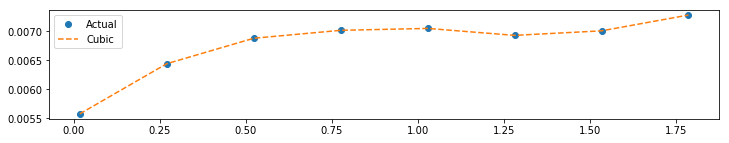

In [209]:
plt.figure(1, figsize=(12,2))
plt.plot(x,y,'o')
plt.plot(x,fitted_LIBOR,'--')
plt.legend(['Actual','Cubic'],loc='best')
plt.show()

In [88]:
# Define the knot points with year notation
knots_year  = [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 
             20.0, 25.0, 31.0, 32.0, 33.0, 34.0, 35.0]
